# Music instrument recognition using deep convolutional neural networks

In [1]:
import json
import math
import time

import tensorflow.keras as keras

import librosa
import librosa.display

import numpy as np

import os

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import re

import pickle
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.models import load_model

### Visualizing Audio Signal

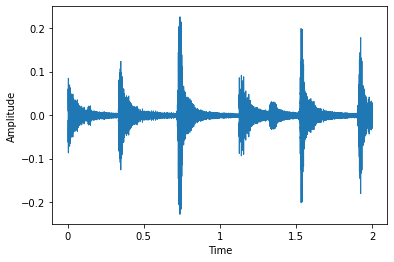

In [2]:
file = 'AudioFiles/Indian/mridangam/mridangam (1).wav'

# Waveform
signal, sr = librosa.load(file, sr = 22050)
librosa.display.waveshow(signal, sr = sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Analyzing Frequency - Power-spectrum

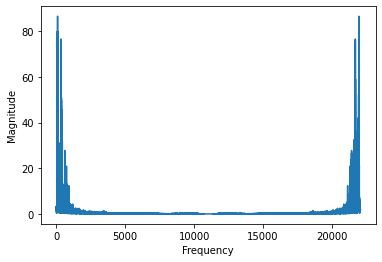

In [3]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

plt.plot(frequency, magnitude)

plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

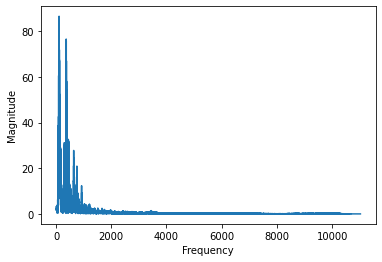

In [4]:
left_frequency = frequency[:int(len(frequency) / 2)]
left_magnitude = magnitude[:int(len(magnitude) / 2)]

plt.plot(left_frequency, left_magnitude)

plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### STFT -> Spectrogram

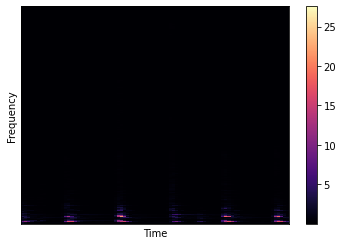

In [5]:
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length = hop_length, n_fft = n_fft)
spectrogram = np.abs(stft)

librosa.display.specshow(spectrogram, sr = sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

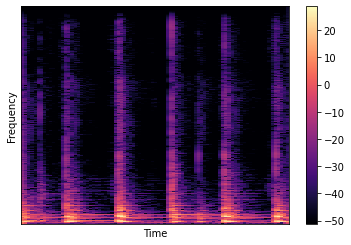

In [6]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr = sr, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

### Plotting MFCCs

C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\3844570871.py:1: FutureWarning: Pass y=[ 0.04615057  0.06186067  0.04709436 ... -0.01157808 -0.01084985
 -0.01135245] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MFFCs = librosa.feature.mfcc(signal, n_fft = n_fft, hop_length = hop_length, n_mfcc = 13)


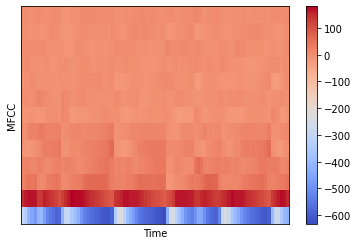

In [7]:
MFFCs = librosa.feature.mfcc(signal, n_fft = n_fft, hop_length = hop_length, n_mfcc = 13)

librosa.display.specshow(MFFCs, sr = sr, hop_length = hop_length)

plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

### Creating Dataset

In [9]:
DATASET_PATH = "AudioFiles/Indian"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050
DURATION = 2
SAMPLE_PER_TRACK = SAMPLE_RATE * DURATION

In [10]:
def save_mfcc(dataset_path, json_path, n_mfcc = 13, n_fft = 2048, hop_length = 512, n_segments = 5):

    # Building dictionary to store data
    data = {
        "mapping" : [],
        "mfcc" : [],
        "labels" : []
    }

    n_samples_per_segment = int(SAMPLE_PER_TRACK / n_segments)
    expected_n_mfcc_vectors_per_segment = math.ceil(n_samples_per_segment / hop_length)

    # Loop through all the instruments
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # Ensure that we are not at the root level
        if dirpath is not dataset_path:

            # Save the semantic label
            dirpath_components = dirpath.split("\\")
            semantic_label = dirpath_components[-1]

            data["mapping"].append(semantic_label)

            print("\nProcessing {}".format(semantic_label))

            # Process files for a specific instrument
            for f in filenames:

                # Loading the audio file
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr = SAMPLE_RATE)

                # Process segments extracting mfcc and storing data
                for s in range(n_segments):
                    start_sample = n_samples_per_segment * s
                    finish_sample = start_sample + n_samples_per_segment

                    # mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, n_fft = n_fft, n_mfcc = n_mfcc, hop_length = hop_length)

                    mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, htk = True, hop_length = hop_length)

                    mfcc = mfcc.T

                # Store mfcc for segment if it has the expected length
                    if len(mfcc) == expected_n_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)

    with open(JSON_PATH, "w") as fp:
        json.dump(data, fp, indent = 4)

if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, n_segments = 10, n_mfcc = 64, hop_length = 1024)


Processing mridangam


C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[ 0.04615057  0.06186067  0.04709436 ... -0.00567121 -0.00593013
 -0.00645705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, htk = True, hop_length = hop_length)
C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[-0.0067689  -0.00683211 -0.00679164 ... -0.00145753 -0.00116357
 -0.00061939] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, htk = True, hop_length = hop_length)
C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[-0.00018103  0.00022004  0.00072298 ... -0.00033518 -0.00022626
 -0.00011314] as keyword args. From version 0.10 passing these as positional argument


Processing sitar


C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, htk = True, hop_length = hop_length)
C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[0.         0.         0.         ... 0.00122328 0.00159455 0.00087768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, htk = True, hop_length = hop_length)
C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[ 0.00090704  0.00125027  0.00103372 ... -0.00347122 -0.00440997
 -0.00422085] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal


Processing tabla


C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[1.7175695e-03 5.4945951e-05 1.2789223e-03 ... 6.1581261e-04 1.4841507e-04
 2.9368171e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, htk = True, hop_length = hop_length)
C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[-0.00094364 -0.00079863  0.00107146 ... -0.04001215 -0.04912305
 -0.05809778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, htk = True, hop_length = hop_length)
C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[-0.06867571 -0.07534498 -0.08250269 ... -0.00826827 -0.00938512
 -0.01070326] as keyword args. From version 0.10 passing these as positio


Processing veena


C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[-0.00476894 -0.02061829 -0.01757935 ...  0.02551371  0.0155728
 -0.00689914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, htk = True, hop_length = hop_length)
C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[-0.02403551 -0.02517948 -0.02122822 ... -0.34419557 -0.19987251
 -0.12084059] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal[start_sample : finish_sample], sr = sr, htk = True, hop_length = hop_length)
C:\Users\aitha\AppData\Local\Temp\ipykernel_16912\2314856357.py:41: FutureWarning: Pass y=[-0.1752256  -0.2712279  -0.2841029  ...  0.00482117 -0.01873737
 -0.05865169] as keyword args. From version 0.10 passing these as positional arguments

# Instrument classification


In [11]:
# Load data
def load_data(dateset_path):
    with open(dateset_path, "r") as fp:
        data = json.load(fp)

    # Convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets

### Defining model history plotting function

In [12]:
# Plotting accuracy and error over the epochs

def plot_history(history):
    fig, axs = plt.subplots(2)

    # Creating accuracy sub-plot
    axs[0].plot(history.history["accuracy"], label = "train accuracy")
    axs[0].plot(history.history["val_accuracy"], label = "test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc = "lower right")
    axs[0].set_title("Accuracy eval")

    # Creating error sub-plot
    axs[1].plot(history.history["loss"], label = "train error")
    axs[1].plot(history.history["val_loss"], label = "test error")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Error")
    axs[1].legend(loc = "upper right")
    axs[1].set_title("Error eval")

    plt.show()

### Defining predicting function

In [17]:
def predict(model, X, y):
    X = X[np.newaxis, ...]

    # prediction = [[4 probabilities]]
    prediction = model.predict(X)

    print("Predicted probabilities : ", prediction)

    # Extract index with max value
    predicted_index = np.argmax(prediction, axis = 1)
    print("Expected index : {}, Predicted index : {}".format(y, predicted_index))


### Defining model training resume capability functions

In [14]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [15]:
def generate_output_dir(outdir, run_desc):
    prev_run_dirs = []
    if os.path.isdir(outdir):
        prev_run_dirs = [x for x in os.listdir(outdir) if os.path.isdir(
            os.path.join(outdir, x))]
    prev_run_ids = [re.match(r'^\d+', x) for x in prev_run_dirs]
    prev_run_ids = [int(x.group()) for x in prev_run_ids if x is not None]
    cur_run_id = max(prev_run_ids, default=-1) + 1
    run_dir = os.path.join(outdir, f'{cur_run_id:05d}-{run_desc}')
    assert not os.path.exists(run_dir)
    os.makedirs(run_dir)
    return run_dir


In [18]:
OUTPUT_DIRECTORY = './resumeData/'
RUN_DESC = "test-train"
BATCH_SIZE = 32
NUM_CLASSES = 4

In [19]:
class MyModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch,logs)

        # Also save the optimizer state
        filepath = self._get_file_path(epoch=epoch,
                                       logs=logs, batch = None)
        filepath = filepath.rsplit( ".", 1 )[ 0 ]
        filepath += ".pkl"

        with open(filepath, 'wb') as fp:
            pickle.dump(
                {
                    'opt': model.optimizer.get_config(),
                    'epoch': epoch+1
                    # Add additional keys if you need to store more values
                }, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('\nEpoch %05d: saving optimizer to %s' % (epoch + 1, filepath))

In [20]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return LearningRateScheduler(schedule)

In [21]:
def load_model_data(model_path, opt_path):
    model = load_model(model_path)
    with open(opt_path, 'rb') as fp:
        d = pickle.load(fp)
        epoch = d['epoch']
        opt = d['opt']
        return epoch, model, opt

In [22]:
def train_model(model, initial_epoch = 0, max_epochs = 10, X_train = None, y_train = None, X_test = None, y_test = None, validation_data = None):
    start_time = time.time()

    checkpoint_cb = MyModelCheckpoint(
        os.path.join(run_dir, 'model-{epoch:02d}-{val_loss:.2f}.hdf5'),
        monitor='val_loss',verbose=1)

    lr_sched_cb = step_decay_schedule(initial_lr = 1e-4, decay_factor = 0.75,
                                      step_size = 2)
    cb = [checkpoint_cb, lr_sched_cb]

    history = model.fit(X_train, y_train,
              batch_size = 32,
              epochs = max_epochs,
              initial_epoch = initial_epoch,
              verbose = 2,
              validation_data = validation_data,
              callbacks = cb
              )

    if X_test is not None:
        score = model.evaluate(X_test, y_test, verbose = 0, callbacks = cb)
        print('Test loss: {}'.format(score[0]))
        print('Test accuracy: {}'.format(score[1]))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    return history

## Neural network 1

In [23]:
run_dir = generate_output_dir(outdir = OUTPUT_DIRECTORY, run_desc = RUN_DESC)
print("Results saved to : {}".format(RUN_DESC))
print(run_dir)

Results saved to : test-train
./resumeData/00009-test-train


In [24]:
if  __name__ == "__main__":
    inputs, targets = load_data(JSON_PATH)

    # Split the data into training and test set
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size = 0.3)

    # Building the network architecture
    model = keras.Sequential(
        [
            # Input layer
            keras.layers.Flatten(input_shape = (inputs.shape[1], inputs.shape[2])),

            # 1st Hidden layer
            keras.layers.Dense(512, activation = "relu"),

            # 2nd Hidden layer
            keras.layers.Dense(256, activation = "relu"),

            # 3rd Hidden layer
            keras.layers.Dense(64, activation = "relu"),

            # Output layer
            keras.layers.Dense(4, activation = "softmax")
        ]
    )

    # Compile the network
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

    model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

    model.summary()

    # Train network
    basicModelHistory = train_model(model = model, initial_epoch = 0, max_epochs = 50, X_train = inputs_train, y_train = targets_train, validation_data = (inputs_test, targets_test))

    # basicModelHistory = basicModel.fit(inputs_train, targets_train, validation_data = (inputs_test, targets_test), epochs = 100, batch_size = 32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 199,748
Trainable params: 199,748
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50

Epoch 1: saving model to ./resumeData/

### Solving over-fitting issue to fix testing accuracy

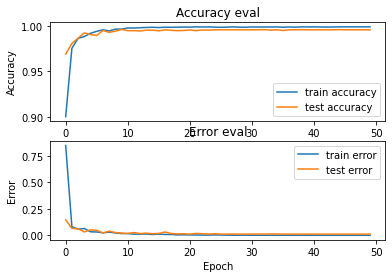

In [25]:
plot_history(basicModelHistory)

In [26]:
run_dir = generate_output_dir(outdir = OUTPUT_DIRECTORY, run_desc = RUN_DESC)
print("Results saved to : {}".format(RUN_DESC))
print(run_dir)

Results saved to : test-train
./resumeData/00010-test-train


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               51712     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)               

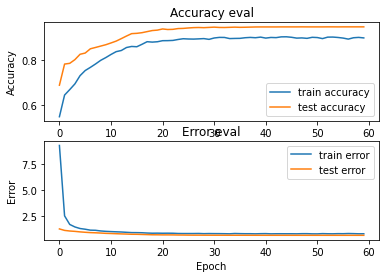

In [27]:
if  __name__ == "__main__":
    inputs, targets = load_data(JSON_PATH)

    # Building the network architecture
    model = keras.Sequential(
        [
            # Input layer
            keras.layers.Flatten(input_shape = (inputs.shape[1], inputs.shape[2])),

            # 1st Hidden layer
            keras.layers.Dense(512, activation = "relu", kernel_regularizer = keras.regularizers.l2(0.001)),
            keras.layers.Dropout(0.3),

            # 2nd Hidden layer
            keras.layers.Dense(256, activation = "relu", kernel_regularizer = keras.regularizers.l2(0.001)),
            keras.layers.Dropout(0.3),

            # 3rd Hidden layer
            keras.layers.Dense(64, activation = "relu", kernel_regularizer = keras.regularizers.l2(0.001)),
            keras.layers.Dropout(0.3),

            # Output layer
            keras.layers.Dense(4, activation = "softmax")
        ]
    )

    # Compile the network
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

    model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

    model.summary()

    # Train network
    basicModelFixHistory = train_model(model = model, initial_epoch = 0, max_epochs = 60, X_train = inputs_train, y_train = targets_train, validation_data = (inputs_test, targets_test))

    # basicModelFixHistory = model.fit(inputs_train, targets_train, validation_data = (inputs_test, targets_test), epochs = 100, batch_size = 32)

plot_history(basicModelFixHistory)


## Neural network 2 - CNN


In [28]:
run_dir = generate_output_dir(outdir = OUTPUT_DIRECTORY, run_desc = RUN_DESC)
print("Results saved to : {}".format(RUN_DESC))
print(run_dir)

Results saved to : test-train
./resumeData/00011-test-train


In [29]:
def prepare_cnn_datasets(test_size, validation_size):
    # Load the data
    X, y = load_data(JSON_PATH)

    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 44)

    # Create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validation_size, random_state = 44)

    # Tensorflow CNN expect 3D array -> (time_bins, number of mfccs, channels = 1)

    X_train = X_train[..., np.newaxis]  # 4d array -> (number of samples, time_bins, number of mfccs, channels = 1)

    X_validation = X_validation[..., np.newaxis]

    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [30]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_cnn_datasets(0.2, 0.2)

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [31]:
def build_cnn_model(input_shape):
    # Create model
    model = keras.Sequential()

    # 1st Conv Layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape, padding = 'same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd Conv Layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape, padding = 'same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd Conv Layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation = 'relu', input_shape = input_shape, padding = 'same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
    model.add(keras.layers.BatchNormalization())

    # 4th Conv Layer
    model.add(keras.layers.Conv2D(512, (3, 3), activation = 'relu', input_shape = input_shape, padding = 'same'))
    model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
    model.add(keras.layers.BatchNormalization())

    # Flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation = 'relu'))
    model.add(keras.layers.Dropout(0.5))

    # Output layer
    model.add(keras.layers.Dense(4, activation = 'softmax'))

    optimizer = keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])

    model.summary()

    return model

In [32]:
model = build_cnn_model(input_shape)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 20, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 10, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 10, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 10, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 5, 64)         0         
 2D)                                                             
                                                      

In [34]:
cnnModelHistory = train_model(model = model, initial_epoch = 0, max_epochs = 30, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, validation_data = (X_validation, y_validation))

Epoch 1/30

Epoch 1: saving model to ./resumeData/00011-test-train\model-01-0.02.hdf5

Epoch 00001: saving optimizer to ./resumeData/00011-test-train\model-01-0.02.pkl
352/352 - 10s - loss: 0.0369 - accuracy: 0.9895 - val_loss: 0.0174 - val_accuracy: 0.9964 - lr: 1.0000e-04 - 10s/epoch - 29ms/step
Epoch 2/30

Epoch 2: saving model to ./resumeData/00011-test-train\model-02-0.01.hdf5

Epoch 00002: saving optimizer to ./resumeData/00011-test-train\model-02-0.01.pkl
352/352 - 10s - loss: 0.0230 - accuracy: 0.9932 - val_loss: 0.0065 - val_accuracy: 0.9975 - lr: 1.0000e-04 - 10s/epoch - 27ms/step
Epoch 3/30

Epoch 3: saving model to ./resumeData/00011-test-train\model-03-0.00.hdf5

Epoch 00003: saving optimizer to ./resumeData/00011-test-train\model-03-0.00.pkl
352/352 - 9s - loss: 0.0109 - accuracy: 0.9970 - val_loss: 0.0036 - val_accuracy: 0.9979 - lr: 7.5000e-05 - 9s/epoch - 27ms/step
Epoch 4/30

Epoch 4: saving model to ./resumeData/00011-test-train\model-04-0.00.hdf5

Epoch 00004: savin

In [35]:
# Storing best model
MODEL_PATH ="./resumeData/00011-test-train/model-30-0.00.hdf5"
OPT_PATH = "./resumeData/00011-test-train/model-30-0.00.pkl"
epoch, model, opt = load_model_data(MODEL_PATH, OPT_PATH)

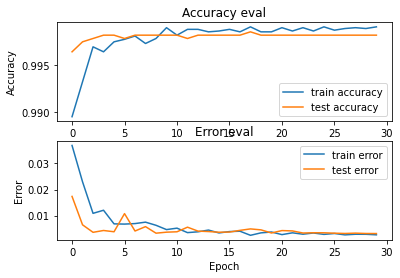

In [36]:
plot_history(cnnModelHistory)

In [45]:
## Resume training
MODEL_PATH ="./resumeData/00007-test-train/model-51-0.62.hdf5"
OPT_PATH = "./resumeData/00007-test-train/model-51-0.62.pkl"
epoch, model, opt = load_model_data(MODEL_PATH, OPT_PATH)

optimizer = keras.optimizers.Adam.from_config(opt)
model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])

cnnModelHistory = train_model(model = model, initial_epoch = epoch, max_epochs = 53, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, validation_data = (X_validation, y_validation))

Epoch 52/53

Epoch 52: saving model to ./resumeData/00007-test-train\model-52-0.90.hdf5

Epoch 00052: saving optimizer to ./resumeData/00007-test-train\model-52-0.90.pkl
2012/2012 - 80s - loss: 0.6019 - accuracy: 0.7959 - val_loss: 0.9002 - val_accuracy: 0.7067 - lr: 7.5254e-08 - 80s/epoch - 40ms/step
Epoch 53/53

Epoch 53: saving model to ./resumeData/00007-test-train\model-53-0.90.hdf5

Epoch 00053: saving optimizer to ./resumeData/00007-test-train\model-53-0.90.pkl
2012/2012 - 89s - loss: 0.6045 - accuracy: 0.7925 - val_loss: 0.9013 - val_accuracy: 0.7075 - lr: 5.6441e-08 - 89s/epoch - 44ms/step
Test loss: 0.9175203442573547
Test accuracy: 0.6996768712997437
Elapsed time: 0:02:54.84


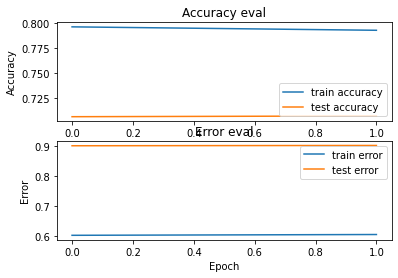

In [46]:
plot_history(cnnModelHistory)

In [37]:
# Make predictions on a sample
X = X_test[100]
y = y_test[100]
predict(model, X, y)

Predicted probabilities :  [[1.7631376e-11 1.6587733e-12 5.8233079e-13 1.0000000e+00]]
Expected index : 3, Predicted index : [3]


## Neural network 3 - RNN-LSTM


In [38]:
run_dir = generate_output_dir(outdir = OUTPUT_DIRECTORY, run_desc = RUN_DESC)
print("Results saved to : {}".format(RUN_DESC))
print(run_dir)

Results saved to : test-train
./resumeData/00012-test-train


In [39]:
def prepare_rnn_datasets(test_size, validation_size):
    # Load the data
    X, y = load_data(JSON_PATH)

    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42)

    # Create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validation_size, random_state = 42)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [40]:
def build_rnn_model(input_shape):
    # Create model
    model = keras.Sequential()

    # 3 LSTM Layers
    model.add(keras.layers.LSTM(32, input_shape = input_shape, return_sequences = True))

    model.add(keras.layers.LSTM(64, return_sequences = True))

    model.add(keras.layers.LSTM(128, return_sequences = True))

    model.add(keras.layers.LSTM(512))

    # Dense layer
    model.add(keras.layers.Dense(64, activation = 'relu'))
    model.add(keras.layers.Dropout(0.5))

    # Output layer
    model.add(keras.layers.Dense(4, activation = 'softmax'))

    model.summary()

    return model

In [42]:
if __name__ == "__main__":

    # Create train, validation, and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_rnn_datasets(0.2, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2])

    # Build the CNN network
    model = build_rnn_model(input_shape)

    # Compile the network
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])

    # Train the RNN
    rnnModelHistory = train_model(model = model, initial_epoch = 0, max_epochs = 30, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, validation_data = (X_validation, y_validation))

    # Evaluate the CNN on the test set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose = 1)
    print("Accuracy on test set = {}".format(test_accuracy))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 5, 64)             24832     
                                                                 
 lstm_6 (LSTM)               (None, 5, 128)            98816     
                                                                 
 lstm_7 (LSTM)               (None, 512)               1312768   
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 4)                

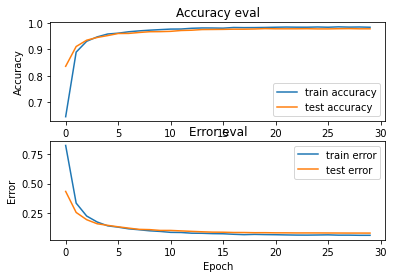

In [43]:
plot_history(rnnModelHistory)

In [ ]:
from tensorflow.python.keras import metrics

matrix = metrics.confusion_matrix(y_test.argmax(axis = 1), y)
